<a href="https://colab.research.google.com/github/aliyaaliyal/mesin-learning/blob/main/yfinance_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Membuat Model Machine Learning dengan Data Time Series**

In [ ]:
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 553 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=cbc0db9742695e1e94c63772bdd8d65352c71d2af9c9328907716983bfcf349b
  Stored in directory: /root/.cache/pip/wheels/6a/90/0c/08c7ac2ce60b9ac91529417d471e59244f9f96848c86f14809
Successfully built yahoofinancials


In [ ]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
df = yf.download('EURUSD=X', 
                      start='2000-01-01', 
                      end='2022-12-01', 
                      progress=False,
)
print(df.head())

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2003-12-01  1.203398  1.204007  1.194401  1.196501   1.196501       0
2003-12-02  1.196101  1.210903  1.194600  1.208897   1.208897       0
2003-12-03  1.209000  1.213003  1.207700  1.212298   1.212298       0
2003-12-04  1.212004  1.214403  1.204398  1.208094   1.208094       0
2003-12-05  1.207802  1.219096  1.206593  1.218695   1.218695       0


In [ ]:
df = df.drop(columns='Open')
df = df.drop(columns='High')
df = df.drop(columns='Low')
df = df.drop(columns='Adj Close')
df = df.drop(columns='Volume')

In [ ]:
df.head()

,Close
Date,
2003-12-01,1.196501
2003-12-02,1.208897
2003-12-03,1.212298
2003-12-04,1.208094
2003-12-05,1.218695


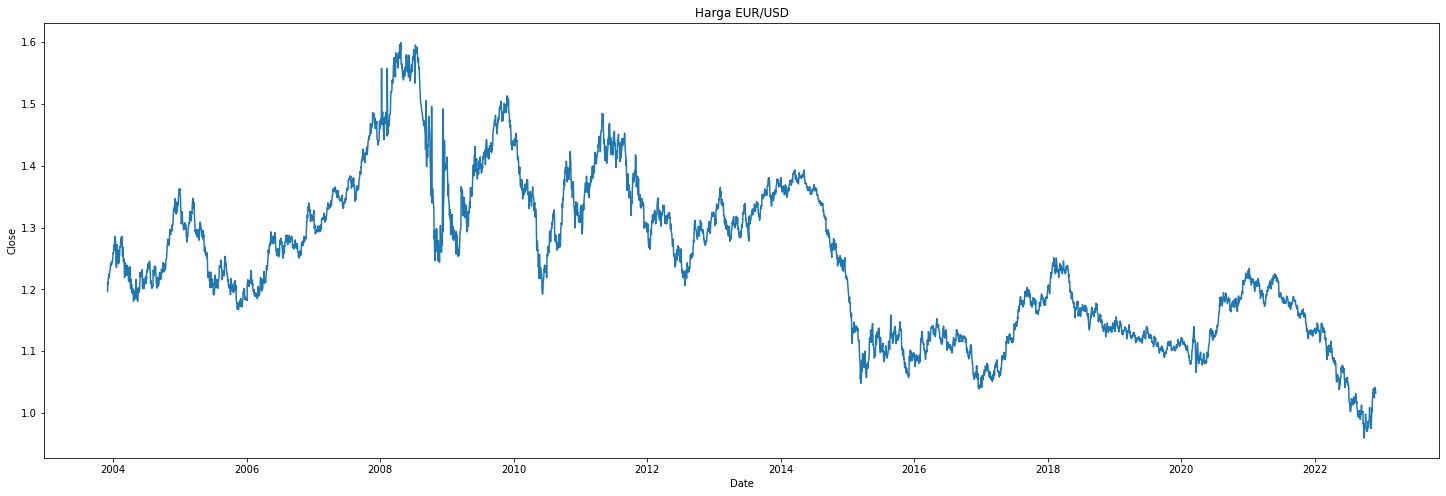

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
plt.plot(df)
plt.title('Harga EUR/USD')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [ ]:
print(df.columns.tolist())

['Close']


In [ ]:
df = df.reset_index(drop = False)

In [ ]:
df.head()

,Date,Close
0,2003-12-01,1.196501
1,2003-12-02,1.208897
2,2003-12-03,1.212298
3,2003-12-04,1.208094
4,2003-12-05,1.218695


In [ ]:
tanggal = df['Date'].values
harga = df['Close'].values
     

In [ ]:
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt
# define contrived series
data = [1.0, 5.5, 9.0, 2.6, 8.8, 3.0, 4.1, 7.9, 6.3]
series = Series(harga)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# normalize the dataset and print
standardized = scaler.transform(values)
print(standardized)

0       1.196501
1       1.208897
2       1.212298
3       1.208094
4       1.218695
          ...   
4924    1.041623
4925    1.040810
4926    1.036753
4927    1.034554
4928    1.032450
Length: 4929, dtype: float64
Mean: 1.245716, StandardDeviation: 0.124465
[[-0.39541213]
 [-0.29581697]
 [-0.26849932]
 ...
 [-1.67889537]
 [-1.69656057]
 [-1.71346625]]


In [ ]:
harga = standardized

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(harga, tanggal, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

3943 986


In [ ]:
# model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
harga

array([[-0.39541213],
       [-0.29581697],
       [-0.26849932],
       ...,
       [-1.67889537],
       [-1.69656057],
       [-1.71346625]])

In [ ]:
max = harga.max()
print('Harga Tertinggi : ' )
print(max)

Harga Tertinggi : 
2.836796901683941


In [ ]:
min = harga.min()
print('Harga Terendah : ' )
print(min)

Harga Terendah : 
-2.298617754576982


In [ ]:
x = (max - min) * (10 / 100)
print(x)

0.5135414656260923


In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x and logs.get('val_mae')<x):
      self.model.stop_training = True
      print("\nTarget MAE dan Val MAE model < 10% skala data sudah tercapai")
callbacks = myCallback()

In [ ]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=1000, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/1000
39/39 [==============================] - 13s 53ms/step - loss: 13.8688 - mae: 14.3590 - val_loss: 15.1509 - val_mae: 15.6486
Epoch 2/1000
39/39 [==============================] - 2s 31ms/step - loss: 11.3036 - mae: 11.7869 - val_loss: 13.2692 - val_mae: 13.7647
Epoch 3/1000
39/39 [==============================] - 2s 30ms/step - loss: 9.1072 - mae: 9.5919 - val_loss: 11.7126 - val_mae: 12.2031
Epoch 4/1000
39/39 [==============================] - 2s 30ms/step - loss: 7.5084 - mae: 7.9944 - val_loss: 10.4877 - val_mae: 10.9772
Epoch 5/1000
39/39 [==============================] - 2s 31ms/step - loss: 6.3910 - mae: 6.8757 - val_loss: 9.5053 - val_mae: 9.9949
Epoch 6/1000
39/39 [==============================] - 2s 32ms/step - loss: 5.6187 - mae: 6.1033 - val_loss: 8.7502 - val_mae: 9.2412
Epoch 7/1000
39/39 [==============================] - 2s 33ms/step - loss: 5.0863 - mae: 5.5700 - val_loss: 8.1382 - val_mae: 8.6273
Epoch 8/1000
39/39 [==============================] - 2s

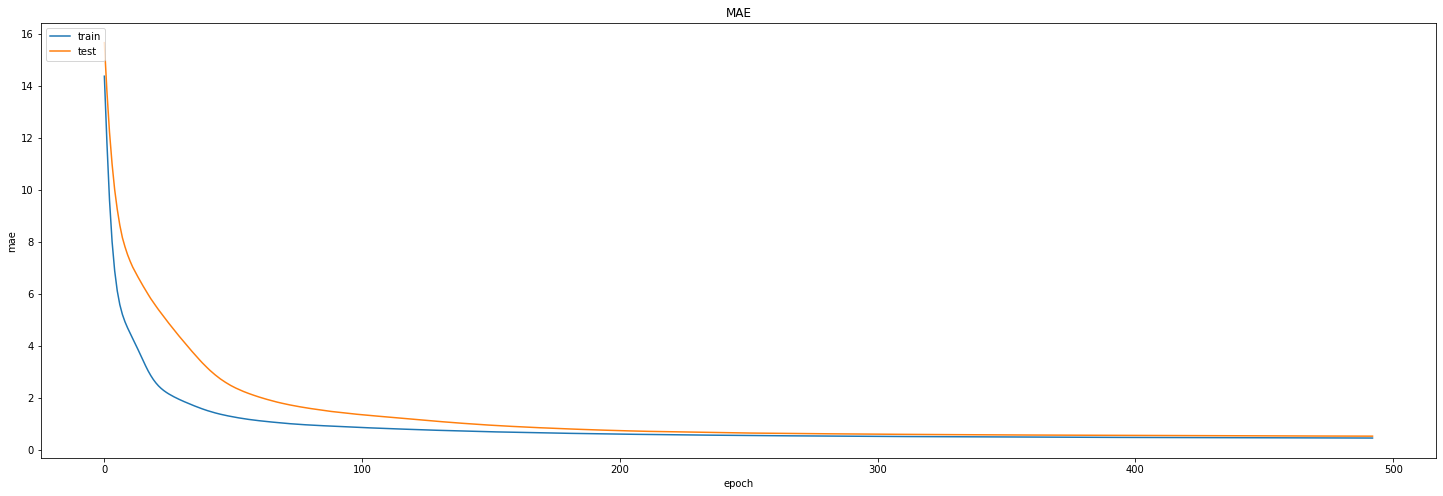

In [ ]:
# plot of mae
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()